In [1]:
import numpy as np
from numpy import random as rnd
import Functions as func
import matplotlib.pyplot as plt
import matplotlib as mpl

# To do
- Integrate with matrix
- create a fetch date from voxel function

# Questions for Stefano
- Is the random number the same for the whole loop?
- anisoropy for the different tissues?
    Saw in a CalTech pres that it was 0.9 for most biological tissues, so we'll use that

In [2]:
#Variables to be declared in the beginning
#for the source
point = np.array([0, 0, 0]) #The coordinate in space where the source is Should be a numpy array
vector = np.array([1, 1, 1]) #direction the source is pointing, should be a numpy array

#scalingFactor to go from units of cm to 0.33mm
scaleFactor = 1 / (0.33*10**(-1))

#Materials info for VIS excitation (wavelength 488nm)
visExSkin = {'u_a' : 6.0, 'u_s' : 625, 'n' : 1.37}
visExfat = {'u_a' : 6.0, 'u_s' : 310, 'n' : 1.45}
visExDuct = {'u_a' : 0.2, 'u_s' : 317, 'n' : 1.42}
cvisExCancer = {'u_a' : 1.0, 'u_s' : 300, 'n' : 1.45}

#Materials info for NIR excitation (wavelength 780nm)
nirExSkin = {'u_a' : 2.0, 'u_s' : 241, 'n' : 1.37}
nirExFat = {'u_a' : 1.4, 'u_s' : 136, 'n' : 1.45}
nirExDuct = {'u_a' : 0.2, 'u_s' : 169, 'n' : 1.42}
nirExCancer = {'u_a' : 1.0, 'u_s' : 150, 'n' : 1.45}

In [3]:
#step 1, generate starting position
pointOnPlane = func.pointOnPlane(vector, point)
print(pointOnPlane)

[ 0.16348276 -0.07830565 -0.08517711]


In [4]:
#step 2, generate a photon with the given start position and direction
photon = func.PhotonClass(1, pointOnPlane, vector)
print(photon.position, photon.direction, photon.weight)

[ 0.16348276 -0.07830565 -0.08517711] [0.57735027 0.57735027 0.57735027] 1


In [5]:
#step 3, determine stepSize (assuming we're in skin)
step = func.determineStepSize(visExSkin['u_a'] + visExSkin['u_s'], scaleFactor)
print(step)

0.012033027651594795


In [6]:
#step 4, Move the photon
photon.movePhoton(step)
print(photon.position)

[ 0.17043003 -0.07135838 -0.07822984]


In [7]:
#step 5, remove weight from photon
photon.removeWeight(visExSkin['u_a'], visExSkin['u_s'])
print(photon.weight)

0.9904912836767037


In [8]:
#step 6, Scatter the photon
photon.scatterPhoton()
print(photon.direction)

[0.48227754 0.51300606 0.71009377]


## Now as a loop

In [9]:
path = []

pointOnPlane = func.pointOnPlane(vector, point)
photon = func.PhotonClass(1, pointOnPlane, vector)


while photon.weight > 0.01:
    path.append(photon.position)
    step = func.determineStepSize(nirExFat['u_a'] + nirExFat['u_s'], scaleFactor)
    photon.movePhoton(step)
    photon.removeWeight(nirExFat['u_a'], nirExFat['u_s'])
    photon.scatterPhoton()
    
path = np.array(path)

In [10]:
path

array([[ -0.33489483,   0.13117134,   0.20372349],
       [ -0.29597821,   0.17008797,   0.24264012],
       [ -0.30558987,   0.19252764,   0.29833349],
       ...,
       [  2.8497308 ,  52.68085575, -19.30595125],
       [  2.71827179,  52.1347445 , -20.18279124],
       [  2.72531115,  52.09170731, -20.27152259]])

In [11]:
#end to end distance of phton path
print(sum((path[0] - path[-1])**(2))**(1/2), "steps:", len(path))


55.93297650445887 steps: 450


# Below is the path of a single photon
As you can see it looks reminiscent to a random walk, which is roughly what is expected.
This is a result for a photon with a 780 nm wavelength in fat tissue

<IPython.core.display.Javascript object>


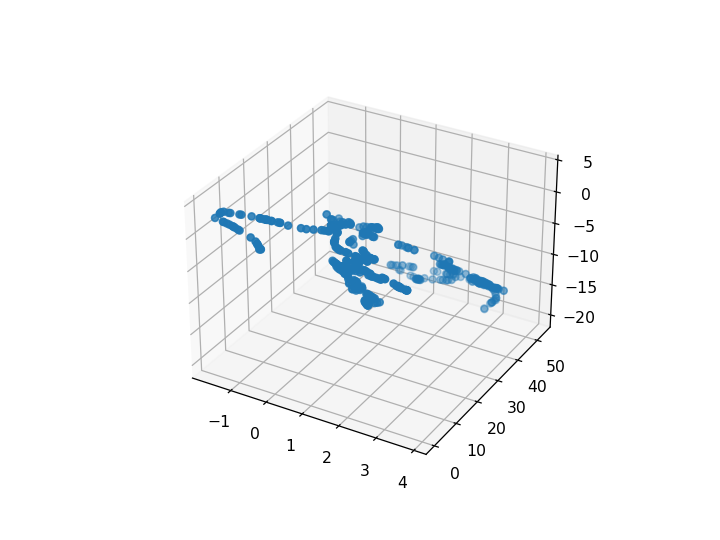

In [12]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(path[:,0], path[:,1], path[:, 2])

# Lets try with more photons
Below we will see the effect of generating many photons. In this example the weight or luminosity they deposit in each voxel will be shown in a size relative diagram. The voxels each photon has vidited will be kept track of in the set path

In [13]:
path = set()
luminosity = {} #dictionary keeping track of the luminosity in voxels where photons have been. key is position, value is luminosity/ deposited weight
#Could the path and luminosity be compined to save data?
N = 1000 #How many photons you want to generate
n = 0 #How many photons have been generated

pointOnPlane = func.pointOnPlane(vector, point, xLength = 0, yLength = 0) #point and vector from earlier.
#to generate points from a single point 
photon = func.PhotonClass(1, pointOnPlane, vector)

while n < N:
    photon = func.PhotonClass(1, pointOnPlane, vector)
    while photon.weight > 0.01: #
        step = func.determineStepSize(nirExFat['u_a'] + nirExFat['u_s'], scaleFactor)
        photon.movePhoton(step)
        dw = photon.removeWeight(nirExFat['u_a'], nirExFat['u_s']) #change in weight of photon/deposited weight in voxel
        photon.scatterPhoton()
        
        a = (int(photon.position[0]), int(photon.position[1]), int(photon.position[2])) #dummy to convert from coordinate to the voxel the coordinate is in
        path.add(a)
        if a in luminosity:
            luminosity[a] += dw
        else:
            luminosity[a] = dw
    n += 1

path = np.array(list(path))
#converted to array to make it easier to graph later

sortedLuminosity = []
for i in path:
    sortedLuminosity.append(luminosity[tuple(i)])

sortedLuminosity = np.array(sortedLuminosity)

<IPython.core.display.Javascript object>


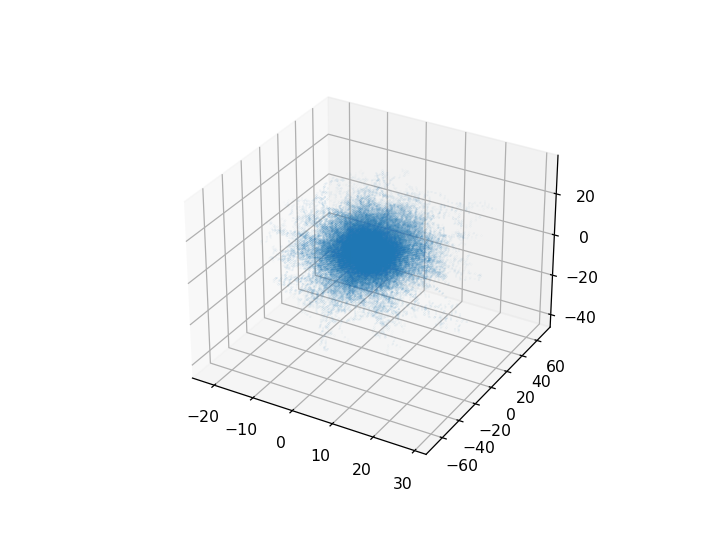

<function matplotlib.pyplot.show(block=None)>

In [14]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection = '3d')
ax.scatter(path[:,0], path[:,1], path[:, 2], s = sortedLuminosity)

plt.show

## Emission phase
Below is an attempt at simulating the emission of photons from nanoparticles in a single tissue model

In [15]:
#1 in 1000 fat tissue cells will be nanoparticles for fat tissue
#1 in 2 for cancer cells maybe
emissionPath = set()
emissionLuminosity = {}
passed = 0

for pos in path:
    a = rnd.random()
    if a < 1/1000:
        passed += 1
        photon = func.PhotonClass(pos[1], pos[0], np.array([rnd.random(), rnd.random(), rnd.random()]))
        while photon.weight > 0.01: #
            step = func.determineStepSize(nirExFat['u_a'] + nirExFat['u_s'], scaleFactor)
            photon.movePhoton(step)
            dw = photon.removeWeight(nirExFat['u_a'], nirExFat['u_s']) #change in weight of photon/deposited weight in voxel
            photon.scatterPhoton()

            a = (int(photon.position[0]), int(photon.position[1]), int(photon.position[2])) #dummy to convert from coordinate to the voxel the coordinate is in
            emissionPath.add(a)
            
            if a in emissionLuminosity:
                emissionLuminosity[a] += dw
            else:
                emissionLuminosity[a] = dw
    else:
        pass

emissionPath = np.array(list(emissionPath))

sortedEmissionLuminosity = []
for i in emissionPath:
    sortedEmissionLuminosity.append(emissionLuminosity[tuple(i)])

sortedEmissionLuminosity = np.array(sortedEmissionLuminosity)

print(passed)

39


<IPython.core.display.Javascript object>


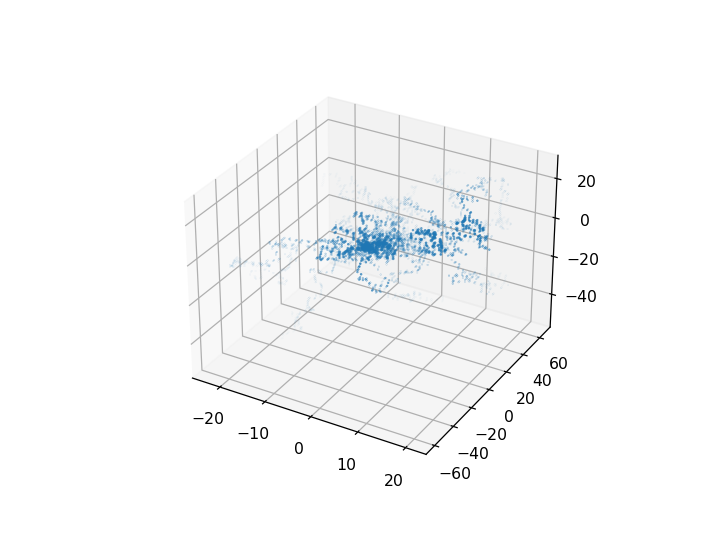

<function matplotlib.pyplot.show(block=None)>

In [16]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection = '3d')
ax.scatter(emissionPath[:,0], emissionPath[:,1], emissionPath[:, 2], s = sortedEmissionLuminosity)

plt.show